In [1]:
import openai
from api_keys import OPEN_AI_API_KEYS
MODEL = 'gpt-4o-mini'
key = OPEN_AI_API_KEYS[0]
client = openai.OpenAI(api_key=key)

In [2]:
def get_completion(
    messages: list[dict[str, str]],
    model: str = "gpt-4o-mini",
    max_tokens=500,
    temperature=0,
    stop=None,
    seed=123,
    tools=None,
    logprobs=None,  # whether to return log probabilities of the output tokens or not. If true, returns the log probabilities of each output token returned in the content of message..
    top_logprobs=None,
) -> str:
    params = {
        "model": model,
        "messages": messages,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "stop": stop,
        "seed": seed,
        "logprobs": logprobs,
        "top_logprobs": top_logprobs,
    }
    if tools:
        params["tools"] = tools

    completion = client.chat.completions.create(**params)
    return completion

In [3]:
import pandas as pd
import numpy as np
import re
import csv
import os
import matplotlib.pyplot as plt

fix all years a-list spreadsheet to be consistent with company names in dataset

start by looking at companies that were only on the a-list in year 5 (2022). 
get ratings for all 5 year's of that company's responses (might not have answered all 5 years)
    after running rating on all companies, can just take from that data (don't rerun prompts)
sanity check: year 5's rating should be better than other years (create a visualization?)

In [10]:
prompt = """Please act as an impartial judge and evaluate the quality of the following 
        response provided by a company to the prompts displayed below. The company may answer 
        either both responses or just one. Your evaluation should consider factors such as the 
        specificity, clarity, completeness, and depth of their responses. In particular, consider 
        the amount of specific tangible action that has been taken in recent years as well as specific
        action items for the commpany to reach future goals. A response should not be rated highly 
        only because of the presence of numbers and statistics about goals. You should decide what score this company should 
        receive on a scale of 1-5 based on the above factors as well as the example responses 
        below of a company that should receive a 5. Avoid falling for greenwashing tactics, such as 
        vague or irrelevant claims and lack of proof of actions. Do not allow the length of the 
        responses to influence your evaluation. Be as objective as possible. There are two prompts, 
        but some companies may only respond to one or the other, with the empty one being denoted with 
        “nan” or "". Do not allow a missing response to influence your decision, but simply ignore it 
        and focus on the other response. """
prompt_no_reference = """Please act as an impartial judge and evaluate the quality of the following 
        response provided by a company to the prompts displayed below. The company may answer 
        either both responses or just one. Your evaluation should consider factors such as the 
        specificity, clarity, completeness, and depth of their responses. In particular, consider 
        the amount of specific tangible action that has been taken in recent years as well as specific
        action items for the commpany to reach future goals. A response should not be rated highly 
        only because of the presence of numbers and statistics about goals. You should decide what score this company should 
        receive on a scale of 1-5 based on the above factors. Avoid falling for greenwashing tactics, such as 
        vague or irrelevant claims and lack of proof of actions. Do not allow the length of the 
        responses to influence your evaluation. Be as objective as possible. There are two prompts, 
        but some companies may only respond to one or the other, with the empty one being denoted with 
        “nan” or "". Do not allow a missing response to influence your decision, but simply ignore it 
        and focus on the other response. """

prompt_v1 = """Please act as an impartial judge and evaluate the quality of the following 
        response provided by a company to the prompts displayed below. The company may answer 
        either both responses or just one. Your evaluation should consider factors such as the 
        specificity, clarity, completeness, and depth of their responses. In addition, consider 
        the amount of tangible action that has been taken in recent years as well as planned action 
        for the future based on the responses. You should decide what score this company should 
        receive on a scale of 1-5 based on the above factors as well as the example responses 
        below of companies that should receive certain scores. Avoid falling for greenwashing tactics, such as 
        vague or irrelevant claims and lack of proof of actions. Do not allow the length of the 
        responses to influence your evaluation. Be as objective as possible. There are two prompts, 
        but some companies may only respond to one or the other, with the empty one being denoted with 
        “nan” or "". Do not allow a missing response to influence your decision, but simply ignore it 
        and focus on the other response. """

prompt_end = """Output your final verdict by strictly following this format of a single number
        1, 2, 3, 4, or 5. It should be a single character without quotations or spaces. 
        Do not provide an explanation"""

example_response_start_5 = "Following is an example of a response that should receive a score of 5. Use this response as a reference for your decision"

example_2018_a = ""
example_2018_b = "Our target is to reduce carbon intensity (tCO2e/m2) by 40% by 2030 compared to a 2013/14 baseline, for property under our management for at least two years. It excludes those properties which are acquired, sold or included in the development pipeline at any time within the last two years. This target includes Scope 1 and 2 emissions, and Scope 3 emissions associated with downstream leased assets (gas and electricity procured by us and used by our occupiers), but excludes Scope 1 emissions associated with refrigerant gas and owned vehicles.In December 2016, the Science Based Targets initiative approved our target, making us the first real estate company in the world to achieve this approval. We calculated our target using the SBTi Sectoral Decarbonisation Approach. This methodology asks companies to assume a % growth factor for their company to calculate an accurate intensity reduction target based upon their absolute emission reduction requirements. Working with the Carbon Trust, we agreed that our company is likely to grow in line with the European real estate average which is 0.7% per annum. This factor has therefore been applied to the baseline portfolio size to project future total portfolio size and required intensity reductions. The figure 33% would be the absolute emission reduction required according to our calculated pathway assuming zero portfolio growth. The same % change anticipated in emissions has been applied to both Scope 1 & 2 and Scope 3. This is because our target covers both Scope 1 & 2 emissions and a selection of Scope 3 emissions. Scope 3 emissions not included within our target have not been incorporated into this calculation.As part of our science based target, we have a longer-term ambition: to reduce our carbon intensity by 80% by 2050, compared to a 2013/14 baseline, for property under our management for at least two years. It excludes those properties which are acquired, sold or included in the development pipeline at any time within this period. This target includes Scope 1 and 2 emissions and Scope 3 emissions associated with downstream leased assets (gas and electricity procured by us and used by our occupiers), but excludes Scope 1 emissions associated with refrigerant gas and owned vehicles.We calculated our target using the SBTi Sectoral Decarbonisation Approach. This methodology asks companies to assume a % growth factor for their company to calculate an accurate intensity reduction target based upon their absolute emission reduction requirements. Working with the Carbon Trust, we agreed that our company is likely to grow in line with the European real estate average which is 0.7% per annum. This factor has therefore been applied to the baseline portfolio size to project future total portfolio size and required intensity reductions. The figure 74% would be the absolute emission reduction required according to our calculated pathway assuming zero portfolio growth. The same % change anticipated in emissions has been applied to both Scope 1 & 2 and Scope 3. This is because our target covers both Scope 1 & 2 emissions and a selection of Scope 3 emissions. Scope 3 emissions not included within our target have not been incorporated into this calculation."
example_2019_a = ""
example_2019_b = "Our target is to reduce carbon intensity (tCO2e/m2) by 40% by 2030 compared to a 2013/14 baseline, for property under our management for at least two years. It excludes those properties which are acquired, sold or included in the development pipeline at any time within the last two years. This target includes Scope 1 and 2 emissions, and Scope 3 emissions associated with downstream leased assets (gas and electricity procured by us and used by our occupiers) but excludes Scope 1 emissions associated with refrigerant gas and owned vehicles. In December 2016, the Science Based Targets initiative approved our target, making us the first real estate company in the world to achieve this approval. We calculated our target using the SBTi Sectoral Decarbonisation Approach. This methodology asks companies to assume a % growth factor for their company to calculate an accurate intensity reduction target based upon their absolute emission reduction requirements. Working with the Carbon Trust, we agreed that our company is likely to grow in line with the European real estate average which is 0.7% per annum. This factor has therefore been applied to the baseline portfolio size to project future total portfolio size and required intensity reductions. The figure 33% would be the absolute emission reduction required according to our calculated pathway assuming zero portfolio growth. The same % change anticipated in emissions has been applied to both Scope 1 & 2 and Scope 3. This is because our target covers both Scope 1 & 2 emissions and a selection of Scope 3 emissions. Scope 3 emissions not included within our target have not been incorporated into this calculation. In 2018/19, we have reduced carbon intensity by 39.8% compared to 2013/14 baseline.As part of our science-based target, we have a longer-term ambition: to reduce our carbon intensity by 80% by 2050, compared to a 2013/14 baseline, for property under our management for at least two years. It excludes those properties which are acquired, sold or included in the development pipeline at any time within this period. This target includes Scope 1 and 2 emissions and Scope 3 emissions associated with downstream leased assets (gas and electricity procured by us and used by our occupiers) but excludes Scope 1 emissions associated with refrigerant gas and owned vehicles. We calculated our target using the SBTi Sectoral Decarbonisation Approach. This methodology asks companies to assume a % growth factor for their company to calculate an accurate intensity reduction target based upon their absolute emission reduction requirements. Working with the Carbon Trust, we agreed that our company is likely to grow in line with the European real estate average which is 0.7% per annum. This factor has therefore been applied to the baseline portfolio size to project future total portfolio size and required intensity reductions. The figure 74% would be the absolute emission reduction required according to our calculated pathway assuming zero portfolio growth. The same % change anticipated in emissions has been applied to both Scope 1 & 2 and Scope 3. This is because our target covers both Scope 1 & 2 emissions and a selection of Scope 3 emissions. Scope 3 emissions not included within our target have not been incorporated into this calculation."
example_2020_a = "Last year we achieved our original 2030 SBT 11 years early, reducing our carbon intensity by 48% since 2014. In line with our aim to lead our sector, in 2019 we became the first UK REIT to increase the ambition level of our science-based carbon reduction target, aligning it to a 1.5-degree scenario (1.5DS). This commitment is one of several steps Landsec is taking to become a net zero carbon business by 2030.Our updated science-based target, now in line with the 1.5DS, is to reduce our absolute carbon emissions (tCO2e) by 70% by 2030 compared to a 2013/14 baseline, for property under our management for at least two years. It excludes those properties which are acquired, sold or included in the development pipeline at any time within the last two years. This target includes Scope 1 and 2 emissions, and Scope 3 emissions associated with downstream leased assets (gas and electricity procured by us and used by our occupiers) but excludes Scope 1 emissions associated with refrigerant gas. To develop this target, the Absolute Contraction Approach was adopted, which applies the annual emission reduction pathway aligned to a 1.5DS to the baseline emissions of the company, and the pathway is defined by a 4.2% annual linear reduction, which has been derived by the Science Based Targets initiative (SBTi). We again worked with the Carbon Trust in order to calculate the emissions pathway for our SBT; the annual reduction aligned to the 1.5DS was applied to our baseline footprint, resulting in the absolute emissions pathway and reduction targets."
example_2020_b = "Our original science-based target was to reduce carbon intensity (tCO2e/m2) by 40% by 2030 compared to a 2013/14 baseline, for property under our management for at least two years. It excluded those properties which are acquired, sold or included in the development pipeline at any time within the last two years. This target included Scope 1 and 2 emissions, and Scope 3 emissions associated with downstream leased assets (gas and electricity procured by us and used by our occupiers) but excluded Scope 1 emissions associated with refrigerant gas and owned vehicles. In December 2016, the Science Based Targets initiative approved our target, making us the first real estate company in the world to achieve this approval. We calculated our target using the SBTi Sectoral Decarbonisation Approach. This methodology asks companies to assume a % growth factor for their company to calculate an accurate intensity reduction target based upon their absolute emission reduction requirements. Working with the Carbon Trust, we agreed that our company is likely to grow in line with the European real estate average which is 0.7% per annum. This factor has therefore been applied to the baseline portfolio size to project future total portfolio size and required intensity reductions. The figure 33% would be the absolute emission reduction required according to our calculated pathway assuming zero portfolio growth. The same % change anticipated in emissions has been was applied to both Scope 1 & 2 and Scope 3. This is because our target covered both Scope 1 & 2 emissions and a selection of Scope 3 emissions. Scope 3 emissions not included within our target have were not been incorporated into this calculation. In 2018/19, we have reduced carbon intensity by 39.8% compared to 2013/14 baseline, and in 2019/20 we achieved our 2030 SBT 11 years early, reducing our carbon intensity by 48% since 2013/14. In line with our aim to lead our sector and key developments in climate science which led the SBTi to update their criteria, in 2019 we became the first UK REIT to increase the ambition level of our science-based carbon reduction target, aligning it to a 1.5-degree scenario. This commitment is one of several steps Landsec is taking to become a net zero carbon business by 2030. Please see C4.1a for more details of our updated SBT."
example_2021_a = "In 2019 we achieved our original 2030 SBT 11 years early, reducing our carbon intensity by 48% since 2014. In line with our aim to lead our sector, in 2019 we became the first UK REIT to increase the ambition level of our science-based carbon reduction target, aligning it to a 1.5-degree scenario (1.5DS). This commitment is one of several steps Landsec is taking to become a net zero carbon business by 2030.Our updated science-based target, now in line with the 1.5DS, is to reduce our absolute carbon emissions (tCO2e) by 70% by 2030 compared to a 2013/14 baseline, for property under our management for at least two years, excluding those properties which are acquired, sold or included in the development pipeline at any time within the last two years. We understand that this two-year period reflects the amount of time needed to undertake sustainability assessments and start implementing changes to the assets; once properties complete the minimum required time under our operational control, they will be included into the commitment portfolio at the start of the following reporting year. This target includes Scope 1 and 2 emissions, and Scope 3 emissions associated with downstream leased assets (gas and electricity procured by us and used by our occupiers) but excludes Scope 1 emissions associated with refrigerant gas. To develop this target, the Absolute Contraction Approach was adopted, which applies the annual emission reduction pathway aligned to a 1.5DS to the baseline emissions of the company, and the pathway is defined by a 4.2% annual linear reduction, which has been derived by the Science Based Targets initiative (SBTi). We again worked with the Carbon Trust in order to calculate the emissions pathway for our SBT; the annual reduction aligned to the 1.5DS was applied to our baseline footprint, resulting in the absolute emissions pathway and reduction targets."
example_2021_b = ""
example_2022_a = "In 2019 we achieved our original 2030 SBT 11 years early, reducing our carbon intensity by 48% since 2014. In line with our aim to lead our sector, in 2019 we became the first UK REIT to increase the ambition level of our science-based carbon reduction target, aligning it to a 1.5-degree scenario (1.5DS). This commitment is the foundation of our transition to net zero.Our updated science-based target, in line with the 1.5DS, is to reduce our absolute carbon emissions (tCO2e) by 70% by 2030 compared to a 2013/14 baseline, for property under our management for at least two years, excluding those properties which are acquired, sold or included in the development pipeline at any time within the last two years. We understand that this two-year period reflects the amount of time needed to undertake sustainability assessments and start implementing changes to the assets; once properties complete the minimum required time under our operational control, they will be included into the commitment portfolio at the start of the following reporting year. This target includes Scope 1 and 2 emissions, and Scope 3 emissions associated with downstream leased assets (gas and electricity procured by us and used by our occupiers) but excludes Scope 1 emissions associated with refrigerant gas. To develop this target, the Absolute Contraction Approach was adopted, which applies the annual emission reduction pathway aligned to a 1.5DS to the baseline emissions of the company, and the pathway is defined by a 4.2% annual linear reduction, which has been derived by the Science Based Targets initiative (SBTi). We worked with the Carbon Trust in order to calculate the emissions pathway for our SBT; the annual reduction aligned to the 1.5DS was applied to our baseline footprint, resulting in the absolute emissions pathway and reduction targets."
example_2022_b = ""


# example_2018_a = ""
# example_2018_b = "Mercialys target aims to reduce the Mercialys greenhouse gas emissions in kgCO2e per visitor by 20% by 2020 compared with 2015. This includes the emissions from Scope 1 and Scope 2 under the location-based method.At the end of the year 2017, the target has already been achieved, since on a like-for-like basis, carbon intensity in kgCO2e/visitor has already decreased by 21.6% between 2015 and 2016.Mercialys is currently developing new GHG targets with the ambition to have them validated by the SBTi before the end of the year 2018."
# example_2019_a = "Mercialys commits to reduce absolute scope 3 GHG emissions from visitors and tenants' travel 26% by 2030 from a 2017 base-year.These emissions are part of the Scope 3 / Other, downstream, as presented in question 6.5."
# example_2019_b = "Mercialys target aims to reduce the Mercialys greenhouse gas emissions in metric tons CO2e per square meter by 47 % by 2030 compared with 2017. This includes the emissions from Scope 1 and Scope 2 under the market-based method.The intensity has already decreased by 5.6% between 2017 and 2018Mercialys commits to reduce scope 3 GHG emissions from tenants' energy consumption 46% per sqm by 2030 from a 2017 base-year.This means reducing the intensity from 0.0541 to 0.038 metric tons CO2e / square meter from 2017 to 2030.In 2018, this target covered 59% of all Scope 3 emissions (excluding other downstream)Mercialys aims to reduce the waste generated in operations by 26% in metric tons CO2e per ton of waste between 2017 and 2030.In 2018, this target covered 3.8 % of all Scope 3 emissions (excluding other downstream)"
# example_2020_a = "Mercialys commits to reduce absolute scope 3 GHG emissions from business travel by 26% by 2030 from a 2017 base-year.These emissions are part of the Scope 3 category / business travel as disclosed in question 6.5"
# example_2020_b = "Mercialys target aims to reduce the Mercialys greenhouse gas emissions in metric tons CO2e per square meter by 47 % by 2030 compared with 2017. This includes the emissions from Scope 1 and Scope 2 under the market-based method.The intensity has already decreased by 18.6% between 2017 and 2019.Mercialys commits to reduce scope 3 GHG emissions from tenants' energy consumption by 46% per sqm by 2030 from a 2017 base-year.This means reducing the intensity from 0.0515 to 0.0278 metric tons CO2e / square meter from 2017 to 2030.In 2019, this target covered 74% of all Scope 3 emissions (excluding other downstream)Mercialys aims to reduce the waste generated in operations by 26% in metric tons CO2e per ton of waste between 2017 and 2030.In 2019, this target covered 4.8 % of all Scope 3 emissions (excluding other downstream)"
# example_2021_a = "Mercialys commits to reduce absolute scope 3 GHG emissions from business travel by 26% by 2030 from a 2017 base-year.These emissions are part of the Scope 3 category / business travel as disclosed in question 6.5.Mercialys had already started to decrease the GHG emissions linked to the business trips in 2019. And the decline in emissions has also been largely impacted by the Covid-19 crisis in 2020."
# example_2021_b = "Mercialys target aims to reduce the Mercialys greenhouse gas emissions in metric tons CO2e per square meter by 47 % by 2030 compared with 2017. This includes the emissions from Scope 1 and Scope 2 under the market-based method.The intensity has already decreased by 13.6% between 2017 and 2020.Mercialys commits to reducing scope 3 GHG emissions from tenants' energy consumption by 46% per sq.m. by 2030 from a 2017 base-year.This means reducing the intensity from 0.0515 to 0.0278 metric tons CO2e / square meter from 2017 to 2030.In 2020, this target covered 85% of all Scope 3 emissions (excluding other downstream)Mercialys aims to reduce the waste generated in operations by 26% in metric tons CO2e per ton of waste between 2017 and 2030.In 2020, this target covered 2.3 % of all Scope 3 emissions (excluding other downstream)"
# example_2022_a = "Mercialys commits to reduce absolute scope 3 GHG emissions from business travel by 26% by 2030 from a 2017 base-year.These emissions are part of the Scope 3 category / business travel as disclosed in question 6.5. All Scope 3 targets altogether  (Abs1, Int2 and Int3) covered 67,08% of all our base year Scope 3 emissions."
# example_2022_b = "Mercialys target aims to reduce the Mercialys greenhouse gas emissions in metric tons CO2e per square meter by 47 % by 2030 compared with 2017. This includes the emissions from Scope 1 and Scope 2 under the market-based method.The intensity has already decreased by 25.9% between 2017 and 2021.Mercialys commits to reducing scope 3 GHG emissions from tenants' energy consumption by 46% per sq.m. by 2030 from a 2017 base-year.This means reducing the intensity from 0.0515 to 0.0278 metric tons CO2e / square meter from 2017 to 2030.In 2021, this target covered 81% of all Scope 3 emissions (excluding other downstream)All Scope 3 targets altogether  (Abs 1, Int 2 and Int 3) covered 67,08% of all our base year Scope 3 emissions.Mercialys aims to reduce the waste generated in operations by 26% in metric tons CO2e per ton of waste between 2017 and 2030.In 2021, this target covered 2.7 % of all Scope 3 emissions (excluding other downstream).All Scope 3 targets altogether  (Abs 1, Int 2 and Int 3) covered 67,08% of all our base year Scope 3 emissions."

# variables for each years' questions
a_2018 = "C4.1a_C12_Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain"
b_2018 = "C4.1b_C13_Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain"
a_2019 = "C4.1a_C12_Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain"
b_2019 = "C4.1b_C13_Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain"
a_2020 = "C4.1a_C15_Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain (including target coverage)"
b_2020 = "C4.1b_C18_Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain (including target coverage)"
a_2021 = "C4.1a_C16_Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain (including target coverage)"
b_2021 = "C4.1b_C19_Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain (including target coverage)"
a_2022 = "C4.1a_C27_Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain target coverage and identify any exclusions"
b_2022 = "C4.1b_C30_Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain target coverage and identify any exclusions"

New final rating prompts

In [4]:
final_prompt_start = """
Please act as an impartial judge and evaluate the quality of the following response provided by a company to the following questions. The company may answer both questions or just one.
"""

final_prompt_general = """
Your evaluation should be primarily based on the tangible action that has already been taken, and can also consider planned actions for the future. Your evaluation should also consider factors such as the specificity, clarity, completeness, and depth of their responses.
Do not allow the length of the responses to influence your evaluation. Do not allow a missing response to influence your decision, but simply ignore it and focus on the other response. Do not fall for greenwashing tactics.
Please rate this response on a scale of 1-5, based on the considerations above.
"""

final_prompt_reference_3 = """
Following is an example of a response that should receive a score of 3. Use this response as a reference for your decision. 
"""
example_response_a_3 = "To grow our business sustainably, we are cutting carbon and maximising energy efficiency. The Science Based Targets initiative (SBTi) has approved our Science Based Targets for Scopes 1, 2 in line with a 1.5-degree pathway and Scope 3 in line with a well below 2-degree pathway.For Scopes 1 and 2, this includes the reduction of greenhouse gas (GHG) emissions from our own operations, aligned with a temperature pathway to limit global warming to 1.5°C. We have committed to achieve Net Zero by 2035. For Scope 3 we are reducing our GHG emissions in the value chain by 30 per cent by 2030.To grow our business sustainably, we are cutting carbon and maximising energy efficiency. The Science Based Targets initiative (SBTi) has approved our Science Based Targets for Scopes 1, 2 in line with a 1.5-degree pathway and Scope 3 in line with a well below 2-degree pathway.For Scopes 1 and 2, these include the reduction of greenhouse gas (GHG) emissions from our own operations, aligned with a temperature pathway to limit global warming to 1.5°C and we have committed to achieve Net Zero by 2035. For Scope 3 we are reducing our GHG emissions in the value chain by 30 per cent by 2030 and this includes reducing emissions from purchased goods, upstream transport and distribution, services sold and our customers'  direct use and consumption of the products we sell."
example_response_b_3 = ""

final_prompt_reference_5 = """
Following is an example of a response that should receive a score of 5. Use this response as a reference for your decision. 
"""

example_response_a_5 = "In 2019 we achieved our original 2030 SBT 11 years early, reducing our carbon intensity by 48% since 2014. In line with our aim to lead our sector, in 2019 we became the first UK REIT to increase the ambition level of our science-based carbon reduction target, aligning it to a 1.5-degree scenario (1.5DS). This commitment is the foundation of our transition to net zero.Our updated science-based target, in line with the 1.5DS, is to reduce our absolute carbon emissions (tCO2e) by 70% by 2030 compared to a 2013/14 baseline, for property under our management for at least two years, excluding those properties which are acquired, sold or included in the development pipeline at any time within the last two years. We understand that this two-year period reflects the amount of time needed to undertake sustainability assessments and start implementing changes to the assets; once properties complete the minimum required time under our operational control, they will be included into the commitment portfolio at the start of the following reporting year. This target includes Scope 1 and 2 emissions, and Scope 3 emissions associated with downstream leased assets (gas and electricity procured by us and used by our occupiers) but excludes Scope 1 emissions associated with refrigerant gas. To develop this target, the Absolute Contraction Approach was adopted, which applies the annual emission reduction pathway aligned to a 1.5DS to the baseline emissions of the company, and the pathway is defined by a 4.2% annual linear reduction, which has been derived by the Science Based Targets initiative (SBTi). We worked with the Carbon Trust in order to calculate the emissions pathway for our SBT; the annual reduction aligned to the 1.5DS was applied to our baseline footprint, resulting in the absolute emissions pathway and reduction targets."
example_response_b_5 = ""

final_prompt_indicative = """
Here is the scale you should use to build your answer:
1. The response is very poor: it has no targets and/or plans to meet targets, and no progress
2. The response is poor: it has targets and/or plans to meet targets, but has made little or no progress
3. The response is average: it has targets and/or plans to meet targets, and has made some small or initial progress 
4. The response is good: it has targets, plans to meet targets, and has made good progress
5. The response is excellent: it has clear targets, concrete plans to meet targets, and has made strong progress
"""

final_prompt_end = """
Please do not provide an explanation. 
Output your final verdict by strictly following this format of a single number 1, 2, 3, 4, or 5. It should be a single character without quotations or spaces. 
"""

In [5]:
question_4a_18 = "Question 1: Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain"
question_4b_18 = "Question 2: Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain"
question_4a_19 = "Question 1: Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain"
question_4b_19 = "Question 2: Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain"
question_4a_20 = "Question 1: Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain (including target coverage)"
question_4b_20 = "Question 2: Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain (including target coverage)"
question_4a_21 = "Question 1: Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain (including target coverage)"
question_4b_21 = "Question 2: Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain (including target coverage)"
question_4a_22 = "Question 1: Provide details of your absolute emissions target(s) and progress made against those targets. - Please explain target coverage and identify any exclusions"
question_4b_22 = "Question 2: Provide details of your emissions intensity target(s) and progress made against those target(s). - Please explain target coverage and identify any exclusions"

In [6]:
def safe_cast_to_int(s):
    try:
        return int(s)
    except ValueError:
        return None 

def get_average(decision_list, percent_list):
    # implement weighted average function
    average = 0
    for rating_number in range(0,5):

        rating = decision_list[rating_number]
        if isinstance(rating, np.int64):
            rating = int(rating)
        if isinstance(rating, str):
            rating = safe_cast_to_int(rating)
        
        if isinstance(rating, int):
            average += rating * (percent_list[rating_number]/100)
        
    return average

In [8]:
# function that checks if a company answered the questionairre in a specific year
def company_exists(company, data_file):
    if company in data_file['Organization'].values:
        return True
    return False

# function that runs prompt on input year (str), company name (str), data_file (pandas dataframe)
def run_rating_prompt(year, company, data_file, question_4a, question_4b):

    answer_a = data_file.loc[data_file['Organization'] == company, question_4a].iloc[0]
    answer_b = data_file.loc[data_file['Organization'] == company, question_4b].iloc[0]

    # get question based on year

    if year == "2018":
        question_4a = question_4a_18
        question_4b = question_4b_18
    if year == "2019":
        question_4a = question_4a_19
        question_4b = question_4b_19
    if year == "2020":
        question_4a = question_4a_20
        question_4b = question_4b_20
    if year == "2021":
        question_4a = question_4a_21
        question_4b = question_4b_21
    if year == "2022":
        question_4a = question_4a_22
        question_4b = question_4b_22

    full_prompt = [
                final_prompt_start,

                question_4a,
                question_4b, 

                final_prompt_general,

                # final_prompt_reference_3,
                # f"[The Start of Question 1 Answer] {example_response_a_3} [The End of Question 1 Answer]",
                # f"[The Start of Question 2 Answer] {example_response_b_3} [The End of Question 2 Answer]",

                final_prompt_reference_5,
                f"[The Start of Question 1 Answer] {example_response_a_5} [The End of Question 1 Answer]",
                f"[The Start of Question 2 Answer] {example_response_b_5} [The End of Question 2 Answer]",

                # final_prompt_indicative,

                final_prompt_end, 
                f"[The Start of Question 1 Answer] {answer_a} [The End of Question 1 Answer]",
                f"[The Start of Question 2 Answer] {answer_b} [The End of Question 2 Answer]"


                # prompt_v1, 
                # f"Prompt 1: {question_4a}",
                # f"Prompt 2: {question_4b}",
                # example_response_start_5,
                # f"[start of example response prompt 1] {example_response_a} [end of example response prompt 1]",
                # f"[start of example response prompt 2] {example_response_b} [end of example response prompt 2]",
                # prompt_end,
                # f"[The Start of Prompt 1 Answer] {answer_a} [The End of Prompt 1 Answer]",
                # f"[The Start of Prompt 2 Answer] {answer_b} [The End of Prompt 2 Answer]"
                ]

    full_prompt_string = ' '.join(full_prompt)

    decision = []
    percent = []
    
    output = get_completion(
        [{"role": "user", "content": full_prompt_string}],
        model="gpt-4o-mini",
        logprobs=True,
        top_logprobs=5,
    )

    top_two_logprobs = output.choices[0].logprobs.content[0].top_logprobs

    for j, logprob in enumerate(top_two_logprobs, start=1):
        decision.append(logprob.token)
        percent.append(np.round(np.exp(logprob.logprob)*100,2))

    average = get_average(decision, percent)
    return average


In [11]:
# read in merged file datasets from each year
data_file_2018 = pd.read_csv("merged_files/2018_merged_dataset.csv")
data_file_2019 = pd.read_csv("merged_files/2019_merged_dataset.csv")
data_file_2020 = pd.read_csv("merged_files/2020_merged_dataset.csv")
data_file_2021 = pd.read_csv("merged_files/2021_merged_dataset.csv")
data_file_2022 = pd.read_csv("merged_files/2022_merged_dataset.csv")

# read in combined a list over years data
a_list_data = pd.read_csv("a-list_data_files/all_years.csv")

# create results file
result_file = "rating_results_over_years/final_prompt_rerun/all_companies_a_list.csv"
fields = ["Company", "2018", "2019", "2020", "2021", "2022", "2018 a-list", "2019 a-list", "2020 a-list", "2021 a-list", "2022 a-list"]

# open file
with open(result_file, 'w', newline='') as csvfile:
    # creating a csv dict writer object
    writer = csv.DictWriter(csvfile, fieldnames=fields, quoting=csv.QUOTE_ALL)
    writer.writeheader()

    # loop through every row to check, exlude last line which is total companies per year
    for index in range(len(a_list_data)-1):
        # get rows where only certain columns are 1 (others are nan)
        # if (not np.isnan(a_list_data['2018'].iloc[index]) and not np.isnan(a_list_data['2019'].iloc[index]) and not np.isnan(a_list_data['2020'].iloc[index]) and not np.isnan(a_list_data['2021'].iloc[index]) and not np.isnan(a_list_data['2022'].iloc[index])):
            
        company = a_list_data['Company'].iloc[index]
        print(company)
        # run prompt on responses for this company for each year one by one
        # write rating score to result file
        
        # only run all years if company answered the questionairre all 5 years
        if (company_exists(company, data_file_2018) and company_exists(company, data_file_2019) and company_exists(company, data_file_2020) and company_exists(company, data_file_2021) and company_exists(company, data_file_2022)):

            result_18 = run_rating_prompt("2018", company, data_file_2018, a_2018, b_2018)
            result_19 = run_rating_prompt("2019", company, data_file_2019, a_2019, b_2019)
            result_20 = run_rating_prompt("2020", company, data_file_2020, a_2020, b_2020)
            result_21 = run_rating_prompt("2021", company, data_file_2021, a_2021, b_2021)
            result_22 = run_rating_prompt("2022", company, data_file_2022, a_2022, b_2022)

            a_list_2018 = "yes"
            a_list_2019 = "yes"
            a_list_2020 = "yes"
            a_list_2021 = "yes"
            a_list_2022 = "yes"

            if (np.isnan(a_list_data['2018'].iloc[index])):
                a_list_2018 = "no"
            if (np.isnan(a_list_data['2019'].iloc[index])):
                a_list_2019 = "no"
            if (np.isnan(a_list_data['2020'].iloc[index])):
                a_list_2020 = "no"
            if (np.isnan(a_list_data['2021'].iloc[index])):
                a_list_2021 = "no"
            if (np.isnan(a_list_data['2022'].iloc[index])):
                a_list_2022 = "no"
                
            # write new line to csv file
            line = {"Company":company, "2018": result_18, "2019":result_19, "2020": result_20, "2021": result_21, "2022": result_22, "2018 a-list": a_list_2018, "2019 a-list":a_list_2019, "2020 a-list": a_list_2020, "2021 a-list": a_list_2021, "2022 a-list": a_list_2022}
            writer.writerow(line)
    
    csvfile.close()

AstraZeneca
Bayer AG
Borregaard ASA
Brembo SpA
BT Group
Danone
Deutsche Bahn AG
Deutsche Telekom AG
EDF
Ferrovial
FIRMENICH SA
J Sainsbury Plc
Koninklijke Philips NV
L'Oréal
Landsec
Mercialys
Metsä Board Corporation
National Grid PLC
Novo Nordisk A/S
Schneider Electric
Signify N.V.
Sopra Steria Group
Telefónica
thyssenkrupp AG
Unibail-Rodamco-Westfield
Unilever plc
Coca-Cola Europacific Partners
Grupo Logista
Pirelli
Accenture
DNB ASA
Carrefour
Kering
REMA1000
Saint-Gobain
Diageo Plc
Klepierre
UBS
Atos SE
Cellnex Telecom SA
ENEL SpA
Givaudan SA
Imperial Brands
Kone Oyj
LANXESS AG
Lundbeck A/S
Ørsted
Royal BAM Group nv
Symrise AG
TETRA PAK
ENGIE
ING Group
Veidekke ASA
The LEGO Group
Intesa Sanpaolo S.p.A
The Navigator Company
Valeo Sa
La Poste
Coca-Cola HBC AG
ENAGAS
HeidelbergCement AG
AENA SME SA
British American Tobacco
Centrica
Gecina
Kingspan Group PLC
Koninklijke KPN NV (Royal KPN)
UPM-Kymmene Corporation
ACCIONA S.A.
Capgemini SE
Carlsberg Breweries A/S
E.ON SE
Holcim Ltd.
Konink

In [12]:
def compare_a_list_years(a_list_18, a_list_19, a_list_20, a_list_21, a_list_22):
    # 5 years
    if (a_list_18 == "yes" and a_list_19 == "yes" and a_list_20 == "yes" and a_list_21 == "yes" and a_list_22 == "yes"):
        return "18,19,20,21,22"
    # 4 years
    elif (a_list_18 == "yes" and a_list_19 == "yes" and a_list_20 == "yes" and a_list_21 == "yes" and a_list_22 == "no"):
        return "18,19,20,21"
    elif (a_list_18 == "yes" and a_list_19 == "yes" and a_list_20 == "yes" and a_list_21 == "no" and a_list_22 == "yes"):
        return "18,19,20,22"
    elif (a_list_18 == "yes" and a_list_19 == "yes" and a_list_20 == "no" and a_list_21 == "yes" and a_list_22 == "yes"):
        return "18,19,21,22"
    elif (a_list_18 == "yes" and a_list_19 == "no" and a_list_20 == "yes" and a_list_21 == "yes" and a_list_22 == "yes"):
        return "18,20,21,22"
    elif (a_list_18 == "no" and a_list_19 == "yes" and a_list_20 == "yes" and a_list_21 == "yes" and a_list_22 == "yes"):
        return "19,20,21,22"
    # 3 years
    elif (a_list_18 == "yes" and a_list_19 == "yes" and a_list_20 == "yes" and a_list_21 == "no" and a_list_22 == "no"):
        return "18,19,20"
    elif (a_list_18 == "yes" and a_list_19 == "yes" and a_list_20 == "no" and a_list_21 == "yes" and a_list_22 == "no"):
        return "18,19,21"
    elif (a_list_18 == "yes" and a_list_19 == "yes" and a_list_20 == "no" and a_list_21 == "no" and a_list_22 == "yes"):
        return "18,19,22"
    elif (a_list_18 == "yes" and a_list_19 == "no" and a_list_20 == "yes" and a_list_21 == "no" and a_list_22 == "yes"):
        return "18,20,22"
    elif (a_list_18 == "yes" and a_list_19 == "no" and a_list_20 == "no" and a_list_21 == "yes" and a_list_22 == "yes"):
        return "18,21,22"
    elif (a_list_18 == "no" and a_list_19 == "yes" and a_list_20 == "yes" and a_list_21 == "yes" and a_list_22 == "no"):
        return "19,20,21"
    elif (a_list_18 == "no" and a_list_19 == "yes" and a_list_20 == "yes" and a_list_21 == "no" and a_list_22 == "yes"):
        return "19,20,22"
    elif (a_list_18 == "no" and a_list_19 == "yes" and a_list_20 == "no" and a_list_21 == "yes" and a_list_22 == "yes"):
        return "19,21,22"
    elif (a_list_18 == "no" and a_list_19 == "no" and a_list_20 == "yes" and a_list_21 == "yes" and a_list_22 == "yes"):
        return "20,21,22"
    # 2 years
    elif (a_list_18 == "yes" and a_list_19 == "yes" and a_list_20 == "no" and a_list_21 == "no" and a_list_22 == "no"):
        return "18,19"
    elif (a_list_18 == "yes" and a_list_19 == "no" and a_list_20 == "yes" and a_list_21 == "no" and a_list_22 == "no"):
        return "18,20"
    elif (a_list_18 == "yes" and a_list_19 == "no" and a_list_20 == "no" and a_list_21 == "yes" and a_list_22 == "no"):
        return "18,21"
    elif (a_list_18 == "no" and a_list_19 == "yes" and a_list_20 == "yes" and a_list_21 == "no" and a_list_22 == "no"):
        return "19,20"
    elif (a_list_18 == "no" and a_list_19 == "yes" and a_list_20 == "no" and a_list_21 == "yes" and a_list_22 == "no"):
        return "19,21"
    elif (a_list_18 == "no" and a_list_19 == "yes" and a_list_20 == "no" and a_list_21 == "no" and a_list_22 == "yes"):
        return "19,22"
    elif (a_list_18 == "no" and a_list_19 == "no" and a_list_20 == "yes" and a_list_21 == "yes" and a_list_22 == "no"):
        return "20,21"
    elif (a_list_18 == "no" and a_list_19 == "no" and a_list_20 == "yes" and a_list_21 == "no" and a_list_22 == "yes"):
        return "20,22"
    elif (a_list_18 == "no" and a_list_19 == "no" and a_list_20 == "no" and a_list_21 == "yes" and a_list_22 == "yes"):
        return "21,22"
    # one year
    elif (a_list_18 == "yes" and a_list_19 == "no" and a_list_20 == "no" and a_list_21 == "no" and a_list_22 == "no"):
        return "18"
    elif (a_list_18 == "no" and a_list_19 == "yes" and a_list_20 == "no" and a_list_21 == "no" and a_list_22 == "no"):
        return "19"
    elif (a_list_18 == "no" and a_list_19 == "no" and a_list_20 == "yes" and a_list_21 == "no" and a_list_22 == "no"):
        return "20"
    elif (a_list_18 == "no" and a_list_19 == "no" and a_list_20 == "no" and a_list_21 == "yes" and a_list_22 == "no"):
        return "21"
    elif (a_list_18 == "no" and a_list_19 == "no" and a_list_20 == "no" and a_list_21 == "no" and a_list_22 == "yes"):
        return "22"
    
    return 0

In [20]:
# graph results by taking average of all ratings per year

# read in a-list and non a-list data files
data_file = pd.read_csv("rating_results_over_years/final_prompt_rerun/all_companies_a_list.csv")
non_a_data_file = pd.read_csv("rating_results_over_years/final_prompt_rerun/non_a_list_all_years.csv") ###################################################
# create results file
result_file = "rating_results_over_years/final_prompt_rerun/averages_of_all_companies.csv"
fields = ["Combination", "total", "2018", "std 2018", "2019", "std 2019", "2020", "std 2020", "2021", "std 2021", "2022", "std 2022"]


# open results file
# read in first company
# for all companies in data_file
    # if no nan values
    # while companies have same combination of a-list years
        # get average of all 2018 ratings
        # get average of all 2019 ratings
        # get average of all 2020 ratings
        # get average of all 2021 ratings
        # get average of all 2022 ratings
        # write to csv file

# open file
with open(result_file, 'w', newline='') as csvfile:
    # creating a csv dict writer object
    writer = csv.DictWriter(csvfile, fieldnames=fields, quoting=csv.QUOTE_ALL)
    writer.writeheader()

    # set up
    # read in first company
    prev_version = compare_a_list_years(data_file.iloc[0]["2018 a-list"],data_file.iloc[0]["2019 a-list"],data_file.iloc[0]["2020 a-list"],data_file.iloc[0]["2021 a-list"],data_file.iloc[0]["2022 a-list"])

    sum_18 = [data_file.iloc[0]["2018"]]
    sum_19 = [data_file.iloc[0]["2019"]]
    sum_20 = [data_file.iloc[0]["2020"]]
    sum_21 = [data_file.iloc[0]["2021"]]
    sum_22 = [data_file.iloc[0]["2022"]]
    total = 1

    for i in range(1, len(data_file)):
        next_version = compare_a_list_years(data_file.iloc[i]["2018 a-list"],data_file.iloc[i]["2019 a-list"],data_file.iloc[i]["2020 a-list"],data_file.iloc[i]["2021 a-list"],data_file.iloc[i]["2022 a-list"])

        # if moving on to new combination
        if next_version != prev_version: 
            # write new line to csv file with means and stds
            line = {"Combination":prev_version, "total":total, "2018": np.mean(sum_18), "std 2018": np.std(sum_18, ddof=0),"2019":np.mean(sum_19), "std 2019": np.std(sum_19, ddof=0),"2020": np.mean(sum_20),  "std 2020": np.std(sum_20, ddof=0),"2021": np.mean(sum_21),  "std 2021": np.std(sum_21, ddof=0),"2022": np.mean(sum_22),  "std 2022": np.std(sum_22, ddof=0)}
            writer.writerow(line)

            # reset sums and total
            sum_18 = [data_file.iloc[i]["2018"]]
            sum_19 = [data_file.iloc[i]["2019"]]
            sum_20 = [data_file.iloc[i]["2020"]]
            sum_21 = [data_file.iloc[i]["2021"]]
            sum_22 = [data_file.iloc[i]["2022"]]
            total = 1

        # if same combination, update all values
        else: 
            sum_18.append(data_file.iloc[i]["2018"])
            sum_19.append(data_file.iloc[i]["2019"])
            sum_20.append(data_file.iloc[i]["2020"])
            sum_21.append(data_file.iloc[i]["2021"])
            sum_22.append(data_file.iloc[i]["2022"])
            total += 1
        # update prev_version
        prev_version = next_version

    # add last combination (only 2022)

    line = {"Combination":prev_version, "total":total, "2018": np.mean(sum_18), "std 2018": np.std(sum_18, ddof=0),"2019":np.mean(sum_19),  "std 2019": np.std(sum_19, ddof=0),"2020": np.mean(sum_20),  "std 2020": np.std(sum_20, ddof=0),"2021": np.mean(sum_21),  "std 2021": np.std(sum_21, ddof=0),"2022": np.mean(sum_22),  "std 2022": np.std(sum_22, ddof=0)}
    writer.writerow(line)

    # add non a list companies
    total = len(non_a_data_file)
    
    avg_18 = np.mean(non_a_data_file["2018"])
    avg_19 = np.mean(non_a_data_file["2019"].tolist())
    avg_20 = np.mean(non_a_data_file["2020"].tolist())
    avg_21 = np.mean(non_a_data_file["2021"].tolist())
    avg_22 = np.mean(non_a_data_file["2022"].tolist())

    std_18 = np.std(non_a_data_file["2018"].tolist(), ddof=0)
    std_19 = np.std(non_a_data_file["2019"].tolist(), ddof=0)
    std_20 = np.std(non_a_data_file["2020"].tolist(), ddof=0)
    std_21 = np.std(non_a_data_file["2021"].tolist(), ddof=0)
    std_22 = np.std(non_a_data_file["2022"].tolist(), ddof=0)

    # calculate std for non a list

    line = {"Combination":"none", "total":total, "2018": avg_18, "std 2018": std_18,"2019":avg_19,  "std 2019": std_19,"2020": avg_20,  "std 2020": std_20,"2021": avg_21,  "std 2021": std_21,"2022": avg_22,  "std 2022": std_22}
    writer.writerow(line)

    csvfile.close()


run on all or random sample of non a list companies

In [18]:
# read in merged file datasets from each year
data_file_2018 = pd.read_csv("merged_files/2018_merged_dataset.csv")
data_file_2019 = pd.read_csv("merged_files/2019_merged_dataset.csv")
data_file_2020 = pd.read_csv("merged_files/2020_merged_dataset.csv")
data_file_2021 = pd.read_csv("merged_files/2021_merged_dataset.csv")
data_file_2022 = pd.read_csv("merged_files/2022_merged_dataset.csv")

# read in combined a list over years data
a_list_data = pd.read_csv("a-list_data_files/all_years.csv")

data_file_2018_filtered = data_file_2018[~data_file_2018['Organization'].isin(a_list_data['Company'])]
random_sample = data_file_2018_filtered.sample(n=200, random_state=7).reset_index(drop=True)  # Set random_state for reproducibility


# create results file
result_file = "rating_results_over_years/final_prompt_rerun/non_a_list_all_years.csv"
fields = ["Company", "2018", "2019", "2020", "2021", "2022"]

# indices = data_file_2018_filtered.index
indices = random_sample.index
print(indices)
print(random_sample)

# open file
with open(result_file, 'w', newline='') as csvfile:
    # creating a csv dict writer object
    writer = csv.DictWriter(csvfile, fieldnames=fields, quoting=csv.QUOTE_ALL)
    writer.writeheader()

    # loop through every row to check, exlude last line which is total companies per year
    #for index in range(len(a_list_data)-1):
    count = 0
    index = 0
    # while index < 650:
    for index in indices:
        company = random_sample['Organization'].iloc[index] ########################################################################################################
        print(company)
        # check if theres is a response in every year
        if (company_exists(company, data_file_2018) and company_exists(company, data_file_2019) and company_exists(company, data_file_2020) and company_exists(company, data_file_2021) and company_exists(company, data_file_2022)):
        # run prompt on responses for this company for each year one by one
        # write rating score to result file
            result_18 = run_rating_prompt("2018", company, data_file_2018, a_2018, b_2018)
            result_19 = run_rating_prompt("2019", company, data_file_2019, a_2019, b_2019)
            result_20 = run_rating_prompt("2020", company, data_file_2020, a_2020, b_2020)
            result_21 = run_rating_prompt("2021", company, data_file_2021, a_2021, b_2021)
            result_22 = run_rating_prompt("2022", company, data_file_2022, a_2022, b_2022)

            # write new line to csv file
            line = {"Company":company, "2018": result_18, "2019":result_19, "2020": result_20, "2021": result_21, "2022": result_22}
            writer.writerow(line)
            count += 1
        # index += 1

    csvfile.close()

RangeIndex(start=0, stop=200, step=1)
             Organization                                            Country  \
0              Logtek Ltd  United Kingdom of Great Britain and Northern I...   
1    dormakaba Holding AG                                        Switzerland   
2                 Pearson  United Kingdom of Great Britain and Northern I...   
3    Dentsu International  United Kingdom of Great Britain and Northern I...   
4               ENTEGA AG                                            Germany   
..                    ...                                                ...   
195           Aker BP ASA                                             Norway   
196                 Gefco                                             France   
197       Gerresheimer AG                                            Germany   
198             Elisa Oyj                                            Finland   
199        Smith & Nephew  United Kingdom of Great Britain and Northern I...   

 

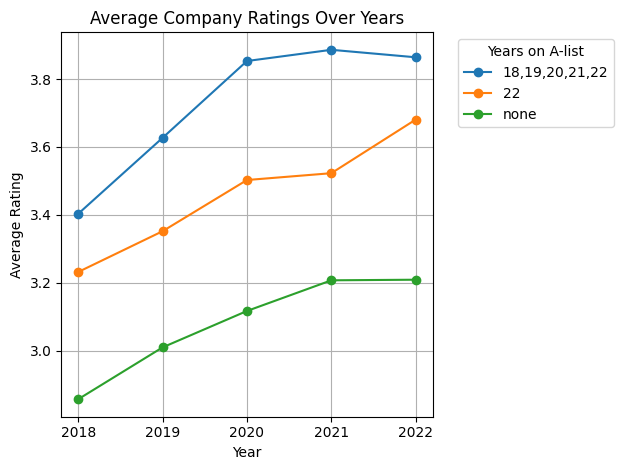

In [21]:
# graph results from averages of all companies
# df = pd.read_csv("rating_results_over_years/9_16_averages_of_all_companies_reference_per_year_v2.csv")
df = pd.read_csv("rating_results_over_years/final_prompt_rerun/averages_of_all_companies.csv")

filtered_df = df[df['total'] > 20]

# for index, row in filtered_df.iterrows():
#     plt.plot(['2018', '2019', '2020', '2021', '2022'], row[['2018', '2019', '2020', '2021', '2022']], marker='o', label=row['Combination'])

for index, row in filtered_df.iterrows():
    # Plot with error bars
    # plt.errorbar(
    #     ['2018', '2019', '2020', '2021', '2022'],  # x values
    #     row[['2018', '2019', '2020', '2021', '2022']],  # y values (ratings)
    #     yerr=row[['std 2018', 'std 2019', 'std 2020', 'std 2021', 'std 2022']],  # standard deviations (error bars)
    #     marker='o', label=row['Combination'], capsize=5  # capsize for error bars
    # )
    # plot without error bars
    # Plot without error bars
    plt.plot(
        ['2018', '2019', '2020', '2021', '2022'],  # x values
        row[['2018', '2019', '2020', '2021', '2022']],  # y values (ratings)
        marker='o', label=row['Combination']  # marker for points
    )

# Add title and labels
plt.title('Average Company Ratings Over Years')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)

# Add a legend to differentiate the combinations
plt.legend(title='Years on A-list', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

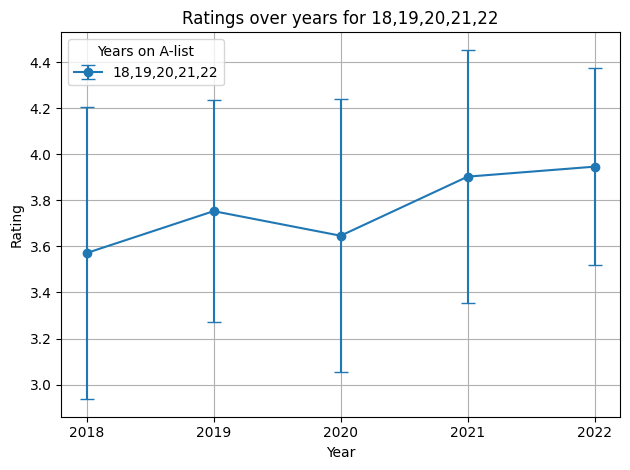

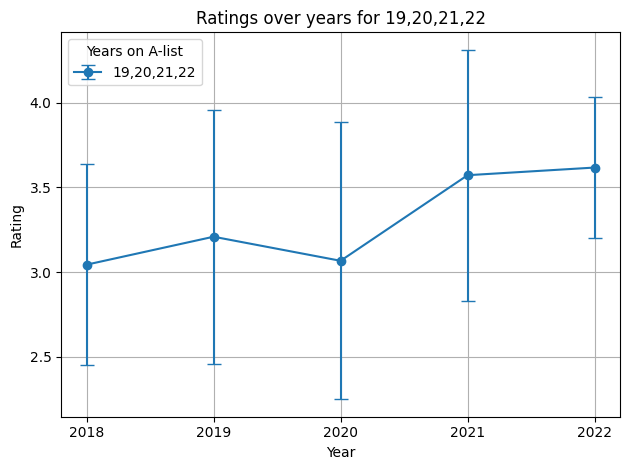

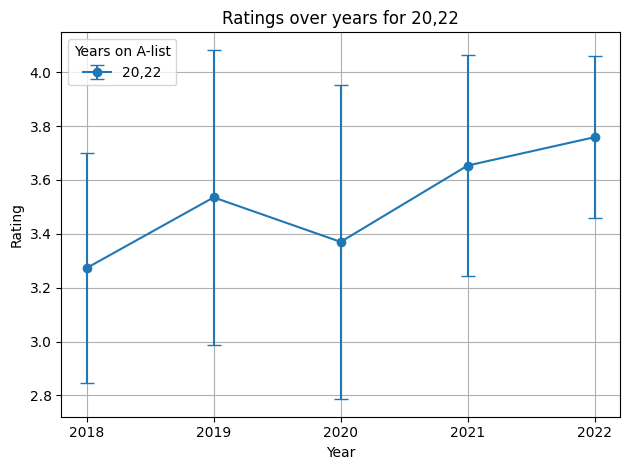

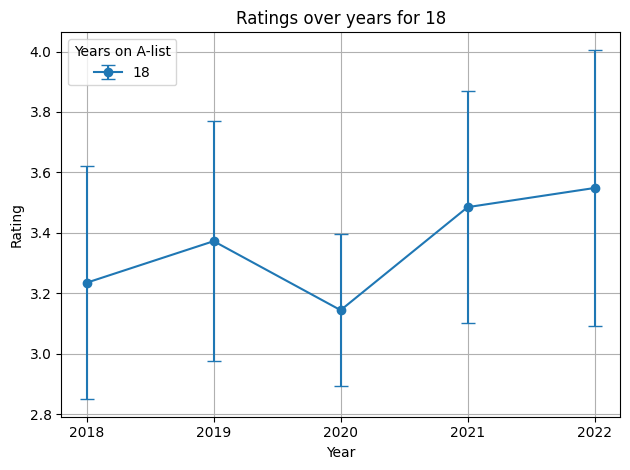

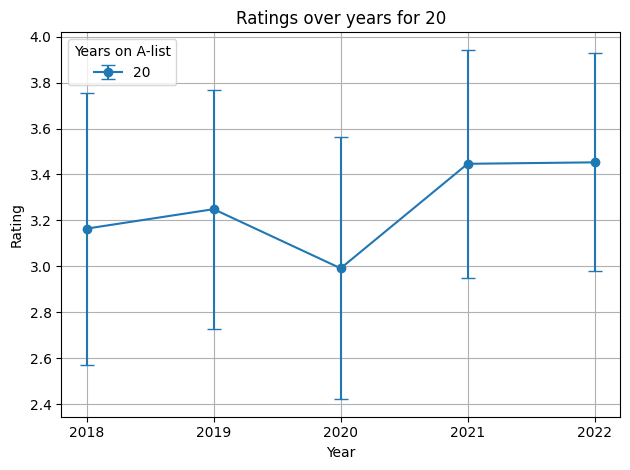

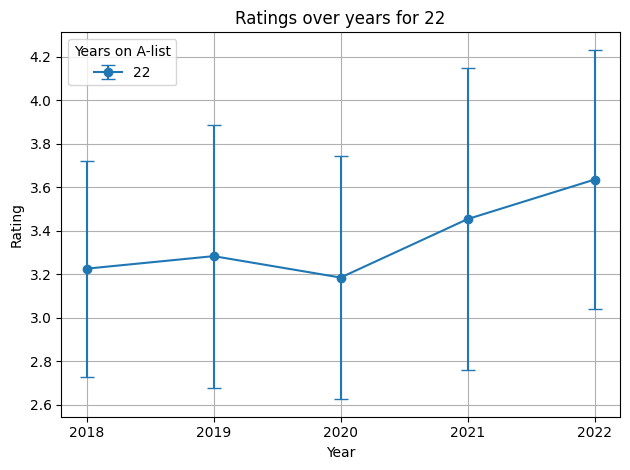

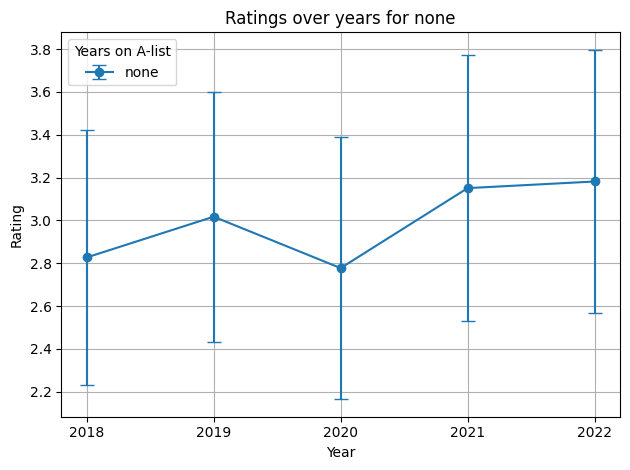

In [5]:

df = pd.read_csv("rating_results_over_years/9_16_averages_of_all_companies_reference_per_year_v2.csv")
filtered_df = df[df['total'] > 8]

for index, row in filtered_df.iterrows():
    plt.figure()  # Create a new figure for each plot
    
    # Plot with error bars
    plt.errorbar(
        ['2018', '2019', '2020', '2021', '2022'],  # x values
        row[['2018', '2019', '2020', '2021', '2022']],  # y values (ratings)
        yerr=row[['std 2018', 'std 2019', 'std 2020', 'std 2021', 'std 2022']],  # standard deviations (error bars)
        marker='o', label=row['Combination'], capsize=5  # capsize for error bars
    )
    
    # Add title and labels
    plt.title(f'Ratings over years for {row["Combination"]}')
    plt.xlabel('Year')
    plt.ylabel('Rating')
    plt.grid(True)
    
    # Add a legend to differentiate the combinations
    plt.legend(title='Years on A-list', loc='upper left')
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()


Year on year change analysis

3.711625
3.7390499999999998


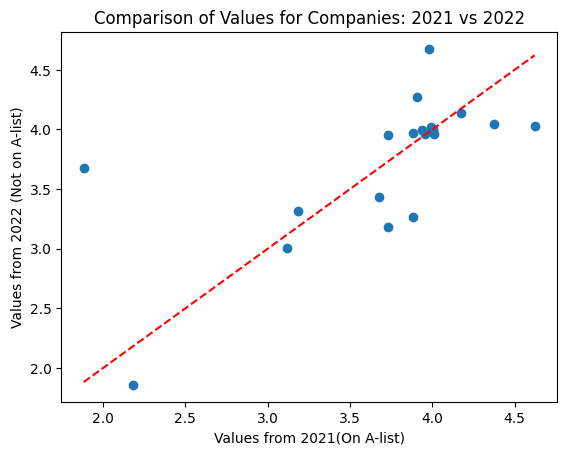

In [75]:
# year 1 on, year 2 off
df = pd.read_csv("rating_results_over_years/9_25_one_reference/all_companies_a_list.csv")

year_1 = "2021"
year_2 = "2022"

non_a_2018 = []
a_2019 = []

# for all companies not on a-list 2018 and on a-list 2019
for i in range (len(df)):
    if df[year_1 + " a-list"].iloc[i] == "yes" and df[year_2 + " a-list"].iloc[i] == "no":
        # if value is not nan
        if not np.isnan(df[year_1].iloc[i]) and not np.isnan(df[year_2].iloc[i]):
            non_a_2018.append(df[year_1].iloc[i])
            a_2019.append(df[year_2].iloc[i])

# compare averages
avg_2018 = np.mean(non_a_2018)
avg_2019 = np.mean(a_2019)

print(avg_2018)
print(avg_2019)

# plot
plt.scatter(non_a_2018, a_2019)

# Add a reference line (y = x) for equal values in both years
plt.plot([min(non_a_2018), max(non_a_2018)], [min(non_a_2018), max(non_a_2018)], color='red', linestyle='--')

# Add title and labels
plt.title('Comparison of Values for Companies: ' + year_1 + ' vs ' + year_2)
plt.xlabel('Values from ' + year_1 + '(On A-list)')
plt.ylabel('Values from ' + year_2 + ' (Not on A-list)')

# Show the plot
plt.show()